In [1]:
import osmnx as ox
from networkx import MultiDiGraph
import random
import requests
import heapq
from math import radians, cos, sin, asin, sqrt


In [2]:
def style_unvisited_edge(graph: MultiDiGraph, edge):
  graph.edges[edge]["color"] = "#d36206"
  graph.edges[edge]["alpha"] = 0.35
  graph.edges[edge]["linewidth"] = 0.4

def style_visited_edge(graph: MultiDiGraph, edge):
  graph.edges[edge]["color"] = "#d36206"
  graph.edges[edge]["alpha"] = 0.7
  graph.edges[edge]["linewidth"] = 0.6

def style_active_edge(graph: MultiDiGraph, edge):
  graph.edges[edge]["color"] = '#e8a900'
  graph.edges[edge]["alpha"] = 0.8
  graph.edges[edge]["linewidth"] = 1

def style_path_edge(graph: MultiDiGraph, edge):
  graph.edges[edge]["color"] = "white"
  graph.edges[edge]["alpha"] = 1
  graph.edges[edge]["linewidth"] = 1.5

def plot_graph(graph: MultiDiGraph, simple_graph):
  node_colors = {
    "source": "blue",
    "destination": "red",
    "default": "white"
  }
  ox.plot_graph(
      graph,
      node_size =  [ simple_graph[node]["size"] for node in graph.nodes ],
      edge_color = [ graph.edges[edge]["color"] for edge in graph.edges ],
      edge_alpha = [ graph.edges[edge]["alpha"] for edge in graph.edges ],
      edge_linewidth = [ graph.edges[edge]["linewidth"] for edge in graph.edges ],
      node_color = [node_colors.get(simple_graph[node]["node_type"], "white") for node in graph.nodes],
      bgcolor = "#18080e"
  )

def plot_heatmap(graph: MultiDiGraph, algorithm):
  edge_colors = ox.plot.get_edge_colors_by_attr(graph, f"{algorithm}_uses", cmap="hot")
  fig, _ = ox.plot_graph(
      graph,
      node_size = 0,
      edge_color = edge_colors,
      bgcolor = "#18080e"
  )


In [22]:
def clean_max_speed(graph: MultiDiGraph):
  for edge in graph.edges:
    edge_data = graph.edges[edge]
    #TODO fix this value
    max_speed = 40
    if "maxspeed" in edge_data:
      max_speeds = edge_data["maxspeed"]
      if isinstance(max_speeds, list):
        speeds = [ int(speed) for speed in max_speeds if speed and speed.isnumeric() ]
        if speeds:
          max_speed = min(speeds)
      elif isinstance(max_speeds, str) and max_speeds.isnumeric():
        max_speed = int(max_speeds)
    edge_data["maxspeed"] = max_speed

def heuristic_weight(graph, node, destination):
  current_latitude = float(graph.nodes[node]["y"])
  current_longitude = float(graph.nodes[node]["x"])
  destination_latitude = float(graph.nodes[destination]["y"])
  destination_longitude = float(graph.nodes[destination]["x"])

  return haversine(current_longitude, current_latitude, destination_longitude, destination_latitude)

def a_star(graph: MultiDiGraph, source, destination, plot=False):
  simple_graph = dict()
  for node in graph.nodes:
    simple_graph[node] = dict()
    simple_graph[node]["visited"] = False
    simple_graph[node]["distance"] = float("inf")
    simple_graph[node]["previous"] = None
    simple_graph[node]["size"] = 0
    simple_graph[node]["node_type"] = "default"

  for edge in graph.edges:
    style_unvisited_edge(graph, edge)

  simple_graph[source]["distance"] = 0

  simple_graph[source]["size"] = 50
  simple_graph[destination]["size"] = 50

  simple_graph[source]["node_type"] = "source"
  simple_graph[destination]["node_type"] = "destination"

  priority_queue = [(0, source)]
  while priority_queue:
    _, node = heapq.heappop(priority_queue)
    if node == destination:
      if plot:
        plot_graph(graph, simple_graph)
      break

    if simple_graph[node]["visited"]:
      continue
    simple_graph[node]["visited"] = True
    for edge in graph.out_edges(node):
      next_node = edge[1]
      visited_edge = (edge[0], next_node, 0)
      style_visited_edge(graph, visited_edge)
      edge_weight = graph.edges[visited_edge]["length"] / 1000
      total_weight = edge_weight + heuristic_weight(graph, next_node, destination)
      total_weight /= graph.edges[visited_edge]["maxspeed"]
      if simple_graph[next_node]["distance"] > simple_graph[node]["distance"] + total_weight:
        simple_graph[next_node]["distance"] = simple_graph[node]["distance"] + total_weight
        simple_graph[next_node]["previous"] = node
        heapq.heappush(priority_queue, (simple_graph[next_node]["distance"], next_node))
        for active_edges in graph.out_edges(next_node):
          style_active_edge(graph, (active_edges[0], active_edges[1], 0))
  return simple_graph

def reconstruct_path(graph: MultiDiGraph, simple_graph, source, destination, plot=False, algorithm=None):
  for edge in graph.edges:
    style_unvisited_edge(graph, edge)
  dist = 0
  time = 0
  current = destination
  while current != source:
    previous = simple_graph[current]["previous"]
    current_length = graph.edges[(previous, current, 0)]["length"] / 1000
    current_max_speed = graph.edges[(previous, current, 0)]["maxspeed"]
    dist += current_length
    time += current_length / current_max_speed
    style_path_edge(graph, (previous, current, 0))
    if algorithm:
      graph.edges[(previous, current, 0)][f"{algorithm}_uses"] = graph.edges[(previous, current, 0)].get(f"{algorithm}_uses", 0) + 1
    current = previous
  if plot:
    print(f"Total dist = {dist}")
    print(f"Total time = {int (time * 60)} min {(time * 60) * 60 - int (time * 60) * 60} sec")
    print(f"Speed average = {dist / time}")
    plot_graph(graph, simple_graph)

def haversine(lon_1, lat_1, lon_2, lat_2):
    lon_1, lat_1, lon_2, lat_2 = map(radians, [lon_1, lat_1, lon_2, lat_2])

    dlon = lon_2 - lon_1
    dlat = lat_2 - lat_1
    a = sin(dlat/2)**2 + cos(lat_1) * cos(lat_2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

def find_nearest_node_from_point(graph: MultiDiGraph, latitude, longitude):
  nearest_node = None
  min_distance = None
  for node in graph.nodes:
    current_latitude = float(graph.nodes[node]["y"])
    current_longitude = float(graph.nodes[node]["x"])
    distance = haversine(longitude, latitude, current_longitude, current_latitude)
    if min_distance is None or distance < min_distance:
      min_distance = distance
      nearest_node = node

  return nearest_node


In [4]:
location = None
point = None

if location is None or point is None:
  response = requests.get("https://ipinfo.io")
  response_json = response.json()
  location = f"{response_json['city']}, {response_json['country']}"
  point = response_json["loc"].strip().split(",")

latitude, longitude = point
latitude = float(latitude)
longitude = float(longitude)


In [5]:
try:
  print("Loading graph...")
  G: MultiDiGraph = ox.graph_from_place(location, network_type="drive")
  print("Successfully loaded graph")
except:
  print("Failed to load the graph")
  raise Exception


Loading graph...
Successfully loaded graph


In [27]:
clean_max_speed(G)

source = find_nearest_node_from_point(G, latitude, longitude)
# destination = random.choice(list(G.nodes))
destination = 170972044
print(f"source: {G.nodes[source]}")
print(f"destination: {G.nodes[destination]}")


source: {'y': 48.1362556, 'x': 11.5747444, 'street_count': 1}
destination: {'y': 48.1581528, 'x': 11.4614155, 'street_count': 3}


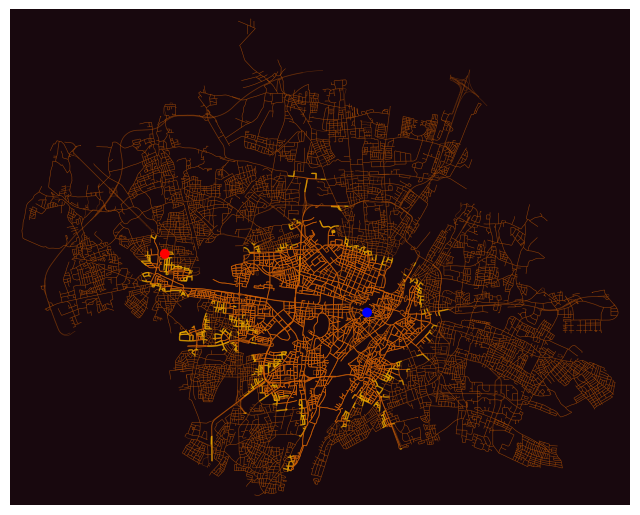

Total dist = 10.926289999999998
Total time = 16 min 23.366100000000188 sec
Speed average = 39.99999999999999


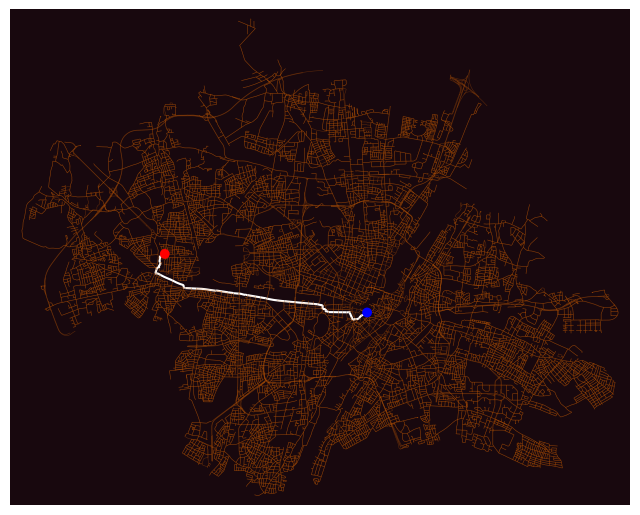

In [28]:
simple_graph = a_star(G, source, destination, plot=True)
reconstruct_path(G, simple_graph, source, destination, plot=True, algorithm="a_star")
